# Pattern Recogintion - Assignment 1

In [1]:
import numpy as np
from PIL import Image as PImage
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
import os
from IPython.display import display

[104 109 104 ...  52  59  56]


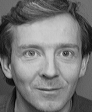

In [2]:
# testing pillow library
image = PImage.open("dataset/s3/9.pgm")
print(np.asarray(image).flatten())
image

## Preparing data

In [3]:
# reading the images, flattening them, and creating data and lavel vectors
NUM_SUBJECTS = 40
NUM_IMAGE_PER_SUBJECT = 10
data_matrix = np.zeros((400, 10304))
image_index = 0
label_vector = np.zeros(400)
for i in range(1, NUM_SUBJECTS + 1):
  for j in range(1, NUM_IMAGE_PER_SUBJECT + 1):
    image = PImage.open(f"dataset/s{i}/{j}.pgm")
    data = np.asarray(image)
    data_matrix[image_index, :] = data.flatten()
    label_vector[image_index] = i
    image_index += 1
    image.close()

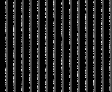

In [5]:
PImage.fromarray(data_matrix[1].reshape((92,112)), 'L')

In [6]:
# splitting the data
total_number_of_data = label_vector.shape[0]
data_trainin_fraction = int(total_number_of_data / 2)
data_testing_fracrion = int(total_number_of_data / 2)

training_data = np.zeros((200,10304))
testing_data = np.zeros((200,10304))

training_labels = np.zeros(200)
testing_labels =  np.zeros(200)

# odd rows are training data
image_index = 0
for i in range(1, 400, 2):
    training_data[image_index, :] = data_matrix[i]
    training_labels[image_index] = label_vector[i]
    image_index += 1  
    
# even rows are testing data
image_index = 0
for i in range(0, 400, 2):
    testing_data[image_index, :] = data_matrix[i]
    testing_labels[image_index] = label_vector[i]
    image_index += 1  


In [7]:
training_labels

array([ 1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
        3.,  3.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  6.,
        6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,
        8.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 11., 11.,
       11., 11., 11., 12., 12., 12., 12., 12., 13., 13., 13., 13., 13.,
       14., 14., 14., 14., 14., 15., 15., 15., 15., 15., 16., 16., 16.,
       16., 16., 17., 17., 17., 17., 17., 18., 18., 18., 18., 18., 19.,
       19., 19., 19., 19., 20., 20., 20., 20., 20., 21., 21., 21., 21.,
       21., 22., 22., 22., 22., 22., 23., 23., 23., 23., 23., 24., 24.,
       24., 24., 24., 25., 25., 25., 25., 25., 26., 26., 26., 26., 26.,
       27., 27., 27., 27., 27., 28., 28., 28., 28., 28., 29., 29., 29.,
       29., 29., 30., 30., 30., 30., 30., 31., 31., 31., 31., 31., 32.,
       32., 32., 32., 32., 33., 33., 33., 33., 33., 34., 34., 34., 34.,
       34., 35., 35., 35., 35., 35., 36., 36., 36., 36., 36., 37

## PCA

In [6]:
# function to compute eigen pairs given a data matrix
def computeEigenPairs(data):

    # calculating mean vector
    miu = np.mean(data, axis=0)

    # centering data
    Z = data - miu

    # calculate covariance matrix
    cov_mat = np.cov(Z.T)
    
    # calculate eigenvalues and eigenvectors
    val, vec = np.linalg.eigh(cov_mat)

    return val, vec, Z

In [7]:
# calculating the eigen pairs. the values and vectors will be used for projection later
val, vec, centered_data = computeEigenPairs(training_data)

In [8]:
# sort eigen values in descending order along with coresponding eigen values 
idx = val.argsort()[::-1]  
val = val[idx]
vec = vec[:,idx]

In [9]:
# calculating smallest r such that f(r) > alpha
# f(r) is current_sum/val_sum
# r will be the number of columns to take from eigen vectors
def getDimensionality(val, alpha):
    r = 0
    current_sum = 0
    val_sum = sum(val)
    for x in range(len(val)):
        if (current_sum/val_sum) < alpha:
            current_sum = current_sum + val[x]
            r = r + 1
#     print(f"r is {r}")
    return r

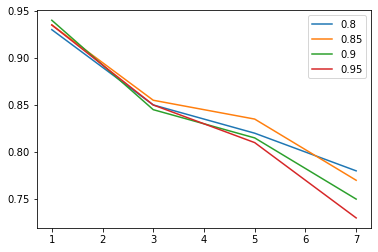

In [10]:
# alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99999]
alpha_list = [0.8, 0.85, 0.9, 0.95]

# k_neighbours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k_neighbours = [1, 3, 5, 7]

accuracy_list = []

for i, alpha in enumerate(alpha_list):
    # calculating smallest r such that f(r) > alpha
    r = getDimensionality(val, alpha)

    # creating projectoin matrix using dimensionality
    projection_matrix = vec[:,0:r]

    # projecting the training set
    mean = np.mean(training_data, axis = 0)
    Z = training_data - mean
    projected_training_data = Z.dot(projection_matrix)

    # other way to project data, not used.
    projected_data2 = projection_matrix.T.dot(Z.T)

    # projecting the test set
    mean = np.mean(testing_data, axis = 0)
    Z = testing_data - mean
    projected_test_data = Z.dot(projection_matrix)
    
    # add extra list for accuracy correspoinding to this alpha value
    accuracy_list.append([])
    
    # Classification and model testing
    for j in k_neighbours:
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(projected_training_data, training_labels)
        accuracy = knn.score(projected_test_data, testing_labels)
        accuracy_list[i].append(accuracy)
        # print(f"alpha={alpha} num_neigbours={j} score={accuracy}")

# plotting the accuracy results
for i in range(len(accuracy_list)):
    plt.plot(k_neighbours, accuracy_list[i], label=alpha_list[i])
plt.legend()

### Observations
It seems that as the value of alpha increases, the accuracy tends to be higher  
for various values of K, however, for one value of alpha, the accuracy tends   
to decrease the more neighbours we consider.

## LDA

In [31]:
# Takes a long time!
def computeEigenPairsLDA(training_data, training_labels, n_classes):
    
    # calculate mean vector for each class
    mean_vector = np.zeros((n_classes, 10304))
    for i in range(1, n_classes+1):
        data = training_data[training_labels == i]
        miu = np.mean(data, axis=0)
        mean_vector[i-1, :] = miu

    # Overall sample mean
    overall_mean = np.mean(training_data, axis=0)
    
    # number of sample in the kth class is always 5 for this application
    Nk = 5

    # between class scatter matrix
    Sb=np.zeros((10304,10304))
    for k in range(1, n_classes+1):
        v = mean_vector[i-1] - overall_mean
        u = v.reshape(10304,1)
        ut = np.array([v])
        Sb += Nk * (np.matmul(u, ut))
        
    # initialize Z matrix that will contain centered class matrices
    Z = np.zeros(training_data.shape)

    # centering class matrices
    for i in range(1,n_classes+1):
        indices = training_labels == i
        Z[indices] = training_data[indices] - mean_vector[i-1]
        
    ## class scatter matrices

    # initialize whithin-class scatter matrix
    S = np.zeros((10304, 10304))

    for i in range(1, n_classes+1):
        Si = Z[training_labels == 1].T.dot(Z[training_labels == 1])
        S += Si

    # calculatign the eigen values/vectors
    S_inv = np.linalg.pinv(S)
    temp = np.dot(S_inv, Sb)
    val_LDA, vec_LDA = np.linalg.eigh(temp)
    
    return val_LDA, vec_LDA, Z

In [37]:
val_LDA, vec_LDA, Z = computeEigenPairsLDA(training_data, training_labels, 40)

MemoryError: Unable to allocate 810. MiB for an array with shape (10304, 10304) and data type float64

In [33]:
# sort eigen values in descending order along with coresponding eigen values 
idx = val_LDA.argsort()[::-1]  
val_LDA = val_LDA[idx]
vec_LDA = vec_LDA[:,idx]

NameError: name 'val_LDA' is not defined

In [ ]:
# The projection matrix - take dominant 39 vectors
projection_matrix_LDA = vec_LDA[:,0:39]

In [ ]:
# calculate mean vector for each class
mean_vector = np.zeros((40, 10304))
for i in range(1, 41):
    data = training_data[training_labels == i]
    miu = np.mean(data, axis=0)
    mean_vector[i-1, :] = miu

# initialize Z matrix for training data
Z = np.zeros(testing_data.shape)

# centering training data
for i in range(1,41):
    indices = testing_labels == i
    Z[indices] = testing_data[indices] - mean_vector[i-1]
    
# projecting the training data
projected_training_data_LDA = Z.dot(projection_matrix_LDA)

In [ ]:
# calculate mean vector for each class
mean_vector = np.zeros((40, 10304))
for i in range(1, 40+1):
    data = testing_data[testing_labels == i]
    miu = np.mean(data, axis=0)
    mean_vector[i-1, :] = miu

# initialize Z matrix for testing data
Z = np.zeros(testing_data.shape)

# centering testing data
for i in range(1,41):
    indices = testing_labels == i
    Z[indices] = testing_data[indices] - mean_vector[i-1]
    
# projecitng testing data
projected_testing_data_LDA = Z.dot(projection_matrix_LDA)

In [ ]:
k_neighbours = [1, 3, 5, 7]
accuracy_list = []

# Classification and model testing
for j in k_neighbours:
    knn = KNeighborsClassifier(n_neighbors=j)
    knn.fit(projected_training_data_LDA, training_labels)
    accuracy = knn.score(projected_testing_data_LDA, testing_labels)
    accuracy_list.append(accuracy)
    
plt.plot(k_neighbours, accuracy_list)

### Observations and comparison with PCA
LDA reports higher accuracy for lower values of K compared to PCA,   
but for higher values of K, the accuracy is much lower

## Face vs not-face classification problem

# First step is transforming new non-face data into same format as image data
the labels in this case will be 1 for not-face, and 2 for face

In [ ]:
# name of the directory in which the image data lies
directory = 'non_face'

# a list containing the names of all files in the directory
file_list = os.listdir(directory)

# These lists will be turned into numpy arrays later
# similar to the initial data matrix, they will contain 
# an array of numerical values representing the images 
data_matrix_no_face = []
label_vector_no_face = []

for filename in file_list:
    image = PImage.open(f"{directory}/{filename}")
    
    # our images are not greyscal, so we need to convert them
    image_greyscale = image.convert('L')
    
    # we need to resize the images to the same size as the face images
    final_image = image_greyscale.resize((92, 112))
    
    # put the image in the mentioned list and add a label (0)
    data_matrix_no_face.append(np.asarray(final_image).flatten())
    label_vector_no_face.append(1)
    
    image.close()

# turn the lists into numpy arrays
data_matrix_no_face = np.array(data_matrix_no_face)
label_vector_no_face = np.array(label_vector_no_face)

In [ ]:
display(final_image)
PImage.fromarray(data_matrix_no_face[0].reshape((92,112)))

In [ ]:
data_matrix_no_face.shape

Second step it to put the face and non face data into the same data matrix

In [ ]:
# merge both data matrices
data_matrix_all = np.vstack((data_matrix, data_matrix_no_face))

# create a label vector of all 1s representing faces from face data
label_vector_temp = np.ones(len(label_vector), dtype='int')*2

# a label vector containing labels of both face and not-face classes
label_vector_all = np.hstack((label_vector_temp, label_vector_no_face))

Third step is splitting the data

In [ ]:
total_number_of_data = label_vector_all.shape[0]
data_trainin_fraction = int(total_number_of_data / 2)
data_testing_fracrion = int(total_number_of_data / 2)

training_data = np.zeros((data_trainin_fraction,10304))
testing_data = np.zeros((data_testing_fracrion,10304))

training_labels = np.zeros(data_trainin_fraction)
testing_labels =  np.zeros(data_testing_fracrion)

# odd rows are training data
image_index = 0
for i in range(1, total_number_of_data, 2):
    training_data[image_index, :] = data_matrix_all[i]
    training_labels[image_index] = label_vector_all[i]
    image_index += 1  
    
# even rows are testing data
image_index = 0
for i in range(0, total_number_of_data, 2):
    testing_data[image_index, :] = data_matrix_all[i]
    testing_labels[image_index] = label_vector_all[i]
    image_index += 1  

In [ ]:
PImage.fromarray(training_data[0].reshape((92,112)), 'L')

In [ ]:
def computeEigenPairs2Class(training_data, training_labels, n_classes):
    
    # calculate mean vector for each class
    mean_vector = np.zeros((n_classes, 10304))
    for i in range(1, n_classes+1):
        data = training_data[training_labels == i]
        miu = np.mean(data, axis=0)
        mean_vector[i-1, :] = miu

    # Overall sample mean
    overall_mean = np.mean(training_data, axis=0)
    
    # between class scatter matrix
    Sb=np.zeros((10304,10304))
    u1 = mean_vector[0] - overall_mean
    u2 = mean_vector[1] - overall_mean
    u1 = u1.reshape(10304, 1)
    u2 = u2.reshape(1, 10304)
    B = (u1-u2).dot((u1-u2).T)

    # initialize Z matrix that will contain centered class matrices
    Z = np.zeros(training_data.shape)

    # centering class matrices
    for i in range(1,n_classes+1):
        indices = training_labels == i
        Z[indices] = training_data[indices] - mean_vector[i-1]
        
    ## class scatter matrices

    # initialize whithin-class scatter matrix
    S = np.zeros((10304, 10304))

    for i in range(1, n_classes+1):
        Si = Z[training_labels == 1].T.dot(Z[training_labels == 1])
        S += Si

    # calculatign the eigen values/vectors
    S_inv = np.linalg.pinv(S)
    temp = np.dot(S_inv, B)
    val_LDA, vec_LDA = np.linalg.eigh(temp)
    
    return val_LDA, vec_LDA, Z

In [ ]:
# calculating Eigenpairs
# Takes too long!
val, vec, Z = computeEigenPairs2Class(training_data, training_labels, 2)

In [ ]:
# sort eigen values in descending order along with coresponding eigen values 
idx = val.argsort()[::-1]  
val = val[idx]
vec = vec[:,idx]

In [ ]:
# calculate mean vector for each class
mean_vector = np.zeros((2, 10304))
for i in range(1, 2+1):
    data = training_data[training_labels == i]
    miu = np.mean(data, axis=0)
    mean_vector[i-1, :] = miu

# The projection matrix - take dominant 40 vectors
projection_matrix_2class = vec[:,0:40]

# projecting the training data
projected_training_data_2class = Z.dot(projection_matrix_2class)

# initialize Z matrix for testing data
Z = np.zeros(training_data.shape)

# centering testing data
for i in range(1,3):
    indices = testing_labels == i
    Z[indices] = testing_data[indices] - mean_vector[i-1]
    
# projecitng testing data
projected_testing_data_2class = Z.dot(projection_matrix_2class)

In [ ]:
k_neighbours = [1, 3, 5, 7]
accuracy_list = []

# Classification and model testing
for j in k_neighbours:
    knn = KNeighborsClassifier(n_neighbors=j)
    knn.fit(projected_training_data_2class, training_labels)
    accuracy = knn.score(projected_testing_data_2class, testing_labels)
    accuracy_list.append(accuracy)
    
plt.plot(k_neighbours, accuracy_list)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(projected_training_data_2class, training_labels)
fail = (knn.predict(projected_testing_data_2class) != testing_labels)

In [ ]:
# attemting to view failed classifications
a = testing_data[fail]
for i in range(len(a)):
    PImage.fromarray(a[i].reshape((92,112)), 'L')

In [34]:
%whos

Variable                  Type                    Data/Info
-----------------------------------------------------------
KNeighborsClassifier      ABCMeta                 <class 'sklearn.neighbors<...>on.KNeighborsClassifier'>
NUM_IMAGE_PER_SUBJECT     int                     10
NUM_SUBJECTS              int                     40
PImage                    module                  <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
Z                         ndarray                 200x10304: 2060800 elems, type `float64`, 16486400 bytes (15.72265625 Mb)
accuracy                  float64                 0.73
accuracy_list             list                    n=4
alpha                     float                   0.95
alpha_list                list                    n=4
centered_data             ndarray                 200x10304: 2060800 elems, type `float64`, 16486400 bytes (15.72265625 Mb)
computeEigenPairs         function                <function computeEigenPai<...>rs at 0x000002C7

In [36]:
import gc
gc.collect()
gc.collect()


0